In [1]:
import time
import torch
import numpy as np
from utils import *
import torch.nn as nn
import pennylane as qml
from typing import List
from qudit_mapping import *
from qutrit_synthesis import *
import matplotlib.pyplot as plt
import torch.nn.functional as F
from itertools import combinations
import torch.distributions as dists
from scipy.linalg import norm, orth
from scipy.sparse.linalg import eigsh
from torch.utils.data import DataLoader
from scipy.sparse import csr_matrix, eye
 
np.set_printoptions(precision=8, linewidth=200)
torch.set_printoptions(precision=8, linewidth=200)

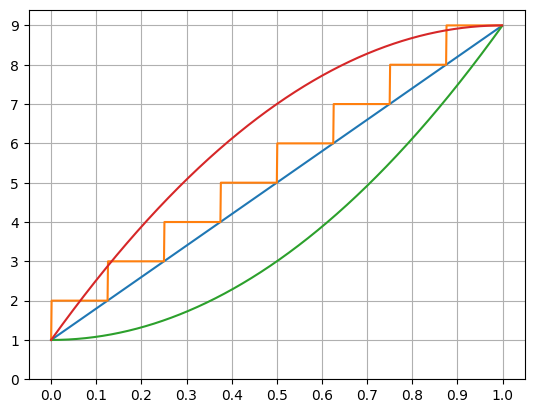

In [2]:
coeff = 8
coeff_funcs = [
    lambda cos_sim: coeff * cos_sim + 1,
    lambda cos_sim: (coeff * cos_sim + 1).ceil(),
    lambda cos_sim: coeff * cos_sim.pow(2) + 1,
    lambda cos_sim: coeff * (2 * cos_sim - cos_sim.pow(2)) + 1,
]
cos_sim = torch.arange(0, 1, 1e-3)

for coeff_func in coeff_funcs:
    plt.plot(cos_sim, coeff_func(cos_sim))
plt.xticks(np.linspace(0, 1, 11))
plt.yticks(np.linspace(0, coeff + 1, coeff + 2))
plt.grid()

In [2]:
epochs = 50
n_layers = 2
n_qudits = 2
batch_size = 10
n_qubits = 2 * n_qudits
n_params = n_layers * (n_qudits - 1) * NUM_PR

dev = qml.device('default.qubit', n_qubits)
if torch.cuda.is_available() and n_qubits >= 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'PyTorch Device: {device}')


def qutrit_symmetric_ansatz(params: torch.Tensor):
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
        two_qutrit_unitary_synthesis(params[i], obj)


@qml.qnode(dev, interface='torch', diff_method='best')
def circuit_state_init(n_layers: int, params: torch.Tensor):
    params = params.reshape(n_layers, n_qudits - 1, NUM_PR)
    qml.layer(qutrit_symmetric_ansatz, n_layers, params)
    return qml.state()

@qml.qnode(dev, interface='torch', diff_method='best')
def circuit_state(n_layers: int, params: torch.Tensor):
    params = params.reshape(n_layers, n_qudits - 1, NUM_PR, batch_size)
    qml.layer(qutrit_symmetric_ansatz, n_layers, params)
    return qml.state()

np.random.seed(42)
params_init = torch.Tensor(np.random.uniform(0, 1, n_params))
state_init = circuit_state_init(n_layers, params_init).to(device)

params = dists.Uniform(0, 1).sample([batch_size, n_params]).to(device)
optimizer = torch.optim.Adam([params.requires_grad_(True)], lr=1e-2)

start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad(set_to_none=True)
    state = circuit_state(n_layers, params)
    cos_sims = torch.empty((0), device=device)
    fidelities = torch.empty((0), device=device)
    for i in range(batch_size):
        cos_sim = torch.cosine_similarity(params_init, params[i], dim=0)
        fidelity = qml.math.fidelity_statevector(state_init, state[i])
        cos_sims = torch.cat((cos_sims, cos_sim.unsqueeze(0)), dim=0)
        fidelities = torch.cat((fidelities, fidelity.unsqueeze(0)), dim=0)
    loss = fidelities.mean() + cos_sims.mean()
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'Loss: {loss.item():.12f}, Fidelity: {fidelities.mean().item():.12f}, Cos_Sim_Max: {cos_sims.max().item():.8f}, Cos_Sim_Mean: {cos_sims.mean().item():.8f}, Cos_Sim_Min: {cos_sims.min().item():.8f}, {count}/{epochs}, {t:.2f}')

PyTorch Device: cpu
Loss: 0.749329573456, Fidelity: 0.039410538022, Cos_Sim_Max: 0.74465847, Cos_Sim_Mean: 0.70991904, Cos_Sim_Min: 0.66186380, 10/50, 2.48
Loss: 0.681691459456, Fidelity: 0.011140993872, Cos_Sim_Max: 0.71073955, Cos_Sim_Mean: 0.67055047, Cos_Sim_Min: 0.61403054, 20/50, 4.93
Loss: 0.625982760911, Fidelity: 0.002881764893, Cos_Sim_Max: 0.66875732, Cos_Sim_Mean: 0.62310100, Cos_Sim_Min: 0.55268496, 30/50, 7.38
Loss: 0.569307589763, Fidelity: 0.000858807796, Cos_Sim_Max: 0.61937380, Cos_Sim_Mean: 0.56844878, Cos_Sim_Min: 0.48517972, 40/50, 9.86
Loss: 0.508785756046, Fidelity: 0.000461550171, Cos_Sim_Max: 0.56801051, Cos_Sim_Mean: 0.50832421, Cos_Sim_Min: 0.41260985, 50/50, 12.24


In [2]:
def qutrit_spin_operator(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_spin_operator2(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s2_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_Hamiltonian(n_qudits: int, beta: float, is_csr: bool = False):
    s1 = qutrit_spin_operator(n_qudits, is_csr=True)
    s2 = qutrit_spin_operator2(n_qudits, is_csr=True)
    Ham = s1 - beta * s2
    if is_csr:
        return Ham
    return Ham.toarray()


sx = csr_matrix([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
sy = csr_matrix([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]]) / np.sqrt(2)
sz = csr_matrix([[1, 0, 0], [0, 0, 0], [0, 0, -1]])
s_list = [sx, sy, sz]
s2_list = [i @ j for i in s_list for j in s_list]
sym_list = [symmetric_encoding(i, is_csr=True) for i in s_list]
sym2_list = [i @ j for i in sym_list for j in sym_list]

beta = -1 / 3
n_qudits = 10
n_qubits = 2 * n_qudits
t1 = time.perf_counter()
ham = qutrit_Hamiltonian(n_qudits, beta, is_csr=True)
t2 = time.perf_counter()
print('Time:', t2 - t1)
eigvals, eigvecs = eigsh(ham, k=4, which='SA')
t3 = time.perf_counter()
print('Time:', t3 - t2)
eigvecs = orth(eigvecs)
t4 = time.perf_counter()
print('Time:', t4 - t3)

for name in range(len(eigvals)):
    print(np.allclose(ham @ eigvecs[:, name], eigvals[name] * eigvecs[:, name], atol=1e-14), norm(eigvecs[:, name], 2), eigvals)
for name in combinations(range(len(eigvals)), 2):
    print(name, fidelity(eigvecs[:, name[0]], eigvecs[:, name[1]]))
t5 = time.perf_counter()
print('Time:', t5 - t4)

mat_path = f'./mats/ED_degeneracy.mat'
# updatemat(mat_path, {f'nqd{n_qudits}': (eigvals, eigvecs)})

Time: 0.4509773000027053
Time: 0.7197592000011355
Time: 0.004684399988036603
True 0.9999999999999989 [-6. -6. -6. -6.]
True 0.9999999999999908 [-6. -6. -6. -6.]
True 0.9999999999999911 [-6. -6. -6. -6.]
True 0.999999999999999 [-6. -6. -6. -6.]
(0, 1) 5.262031812585885e-31
(0, 2) 1.5703190172182841e-30
(0, 3) 2.7731593163017182e-30
(1, 2) 8.15760146820935e-30
(1, 3) 1.8224112098764237e-31
(2, 3) 3.5292666230896135e-32
Time: 0.008185999991837889


In [2]:
import time
import torch
import numpy as np
import pennylane as qml
from typing import List
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=8, linewidth=200)
torch.set_printoptions(precision=4, linewidth=200)


def running(n_qudits: int, epochs: int):
    n_layers = 2
    beta = -1 / 3
    n_qubits = 2 * n_qudits
    dev = qml.device('default.qubit', n_qubits)
    device = torch.device('cpu')

    def spin_operator(obj: List[int]):
        if len(obj) != 2:
            raise ValueError(f'The number of object qubits {len(obj)} should be 2')
        sx = qml.X(obj[0]) + qml.X(obj[1])
        sy = qml.Y(obj[0]) + qml.Y(obj[1])
        sz = qml.Z(obj[0]) + qml.Z(obj[1])
        return sx, sy, sz

    def spin_operator2(obj: List[int]):
        if len(obj) != 2:
            raise ValueError(f'The number of object qubits {len(obj)} should be 2')
        s1 = spin_operator(obj)
        s2 = [i @ j for i in s1 for j in s1]
        return s2

    def Hamiltonian(n_qudits: int, beta: float):
        ham1, ham2 = 0, 0
        for i in range(n_qudits - 1):
            obj1 = [2 * i, 2 * i + 1]
            obj2 = [2 * i + 2, 2 * i + 3]
            ham1 += qml.sum(*[spin_operator(obj1)[i] @ spin_operator(obj2)[i] for i in range(3)])
            ham2 += qml.sum(*[spin_operator2(obj1)[i] @ spin_operator2(obj2)[i] for i in range(9)])
        Ham = ham1 / 4 - beta * ham2 / 16
        coeffs, obs = qml.simplify(Ham).terms()
        coeffs = torch.tensor(coeffs).real
        Ham = qml.Hamiltonian(coeffs, obs)
        return Ham

    def qutrit_symmetric_ansatz(params: torch.Tensor):
        for i in range(n_qudits - 1):
            obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
            two_qutrit_unitary_synthesis(params[i], obj)

    @qml.qnode(dev, interface='torch', diff_method='best')
    def circuit_expval(n_layers: int, params: torch.Tensor, Ham):
        params = params.reshape(n_layers, n_qudits - 1, NUM_PR)
        qml.layer(qutrit_symmetric_ansatz, n_layers, params)
        return qml.expval(Ham)

    np.random.seed(42)
    n_params = n_layers * (n_qudits - 1) * NUM_PR
    params_init = np.random.uniform(-np.pi, np.pi, n_params)
    params = torch.tensor(params_init, device=device, requires_grad=True)
    optimizer = torch.optim.Adam([params], lr=1e-3)
    Ham = Hamiltonian(n_qudits, beta)
    print(Ham)

    start = time.perf_counter()
    for epoch in range(epochs):
        optimizer.zero_grad(set_to_none=True)
        loss = circuit_expval(n_layers, params, Ham)
        loss.backward()
        optimizer.step()
        t = time.perf_counter() - start
        print(f'Loss: {loss.item():.20f}, {epoch+1}/{epochs}, {t:.2f}')


running(n_qudits=6, epochs=10)

0.20833333333333334 * (X(0) @ X(2)) + 0.20833333333333334 * (X(0) @ X(3)) + 0.20833333333333334 * (X(1) @ X(2)) + 0.20833333333333334 * (X(1) @ X(3)) + 0.20833333333333334 * (Y(0) @ Y(2)) + 0.20833333333333334 * (Y(0) @ Y(3)) + 0.20833333333333334 * (Y(1) @ Y(2)) + 0.20833333333333334 * (Y(1) @ Y(3)) + 0.20833333333333334 * (Z(0) @ Z(2)) + 0.20833333333333334 * (Z(0) @ Z(3)) + 0.20833333333333334 * (Z(1) @ Z(2)) + 0.20833333333333334 * (Z(1) @ Z(3)) + 0.20833333333333334 * (X(2) @ X(4)) + 0.20833333333333334 * (X(2) @ X(5)) + 0.20833333333333334 * (X(3) @ X(4)) + 0.20833333333333334 * (X(3) @ X(5)) + 0.20833333333333334 * (Y(2) @ Y(4)) + 0.20833333333333334 * (Y(2) @ Y(5)) + 0.20833333333333334 * (Y(3) @ Y(4)) + 0.20833333333333334 * (Y(3) @ Y(5)) + 0.20833333333333334 * (Z(2) @ Z(4)) + 0.20833333333333334 * (Z(2) @ Z(5)) + 0.20833333333333334 * (Z(3) @ Z(4)) + 0.20833333333333334 * (Z(3) @ Z(5)) + 0.20833333333333334 * (X(4) @ X(6)) + 0.20833333333333334 * (X(4) @ X(7)) + 0.2083333333

In [3]:
def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) + qml.X(obj[1])
    sy = qml.Y(obj[0]) + qml.Y(obj[1])
    sz = qml.Z(obj[0]) + qml.Z(obj[1])
    return sx, sy, sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = spin_operator(obj)
    s2 = [i @ j for i in s1 for j in s1]
    return s2


def Hamiltonian(n_qudits: int, beta: float):
    ham1, ham2 = 0, 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        ham1 += qml.sum(*[spin_operator(obj1)[i] @ spin_operator(obj2)[i] for i in range(3)])
        ham2 += qml.sum(*[spin_operator2(obj1)[i] @ spin_operator2(obj2)[i] for i in range(9)])
    Ham = ham1 / 4 - beta * ham2 / 16
    coeffs, obs = qml.simplify(Ham).terms()
    coeffs = torch.tensor(coeffs).real
    Ham = qml.Hamiltonian(coeffs, obs)
    return Ham


def qutrit_spin_operator(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_spin_operator2(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((3**n_qudits, 3**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 3**i, 3**(n_qudits - i - 2)
        for j in s2_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qutrit_Hamiltonian(n_qudits: int, beta: float, is_csr: bool = False):
    s1 = qutrit_spin_operator(n_qudits, is_csr=True)
    s2 = qutrit_spin_operator2(n_qudits, is_csr=True)
    Ham = s1 - beta * s2
    if is_csr:
        return Ham
    return Ham.toarray()


def qubit_spin_operator(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((4**n_qudits, 4**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 4**i, 4**(n_qudits - i - 2)
        for j in sym_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qubit_spin_operator2(n_qudits: int, is_csr: bool = False):
    ss = csr_matrix((4**n_qudits, 4**n_qudits), dtype=CDTYPE)
    for i in range(n_qudits - 1):
        d1, d2 = 4**i, 4**(n_qudits - i - 2)
        for j in sym2_list:
            ss += tensor_product_sparse(eye(d1), j, j, eye(d2))
    if is_csr:
        return ss
    return ss.toarray()


def qubit_Hamiltonian(n_qudits: int, beta: float, is_csr: bool = False):
    s1 = qubit_spin_operator(n_qudits, is_csr=True)
    s2 = qubit_spin_operator2(n_qudits, is_csr=True)
    if is_csr:
        return s1 - beta * s2
    return (s1 - beta * s2).toarray()


sx = csr_matrix([[0, 1, 0], [1, 0, 1], [0, 1, 0]]) / np.sqrt(2)
sy = csr_matrix([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]]) / np.sqrt(2)
sz = csr_matrix([[1, 0, 0], [0, 0, 0], [0, 0, -1]])
s_list = [sx, sy, sz]
s2_list = [i @ j for i in s_list for j in s_list]
sym_list = [symmetric_encoding(i, is_csr=True) for i in s_list]
sym2_list = [i @ j for i in sym_list for j in sym_list]

n_qudits, beta = 7, -0.3
Ham = Hamiltonian(n_qudits, beta)
h1 = csr_matrix(Ham.matrix())
h2 = qubit_Hamiltonian(n_qudits, beta, is_csr=True)
h3 = qutrit_Hamiltonian(n_qudits, beta, is_csr=True)

v1 = np.sort(eigsh(h2, k=6, which='SA', return_eigenvectors=False))
v2 = np.sort(eigsh(h2, k=6, which='SA', return_eigenvectors=False))
print(v1)
print(v2)
np.allclose(v1, v2)

[-4.40869948 -4.40869948 -4.40869948 -4.40233539 -3.68159428 -3.68159428]
[-4.40869948 -4.40869948 -4.40869948 -4.40233539 -3.68159428 -3.68159428]


True

In [3]:
start = time.perf_counter()
print('L', end=' 　')
beta_list = [-0.3, -0.2, -0.1, 0.0, 0.4]
for beta in beta_list:
    if beta < 0:
        print(f'β = {beta:.2f}', end='　')
    else:
        print(f'β = +{beta:.2f}', end='　')
print('Time')
for n_qudits in [4, 5, 6, 7, 8, 9]:
    start_nq = time.perf_counter()
    print(n_qudits, end=' 　')
    s1 = qubit_spin_operator(n_qudits, is_csr=True)
    s2 = qubit_spin_operator2(n_qudits, is_csr=True)
    for beta in beta_list:
        ham = s1 - beta * s2
        eigvals = eigsh(ham, k=4, which='SA', return_eigenvectors=False)
        eigvals = sorted(eigvals)
        vals = np.array(eigvals[:1])
        for v1 in eigvals[1:]:
            for v2 in vals:
                if np.abs(v1 - v2) < 1e-12:
                    break
            else:
                vals = np.append(vals, v1)
        diff = vals[0] - vals[1]
        print(f'{diff:.6f}', end='　')
    end_nq = time.perf_counter()
    print(f'{(end_nq-start_nq):.2f}')
end = time.perf_counter()
total = end - start
if total >= 60:
    print(f'Total time: {total//60:.0f}m{total%60:.2f}s')
else:
    print(f'Total time: {total:.2f}s')

L 　β = -0.30　β = -0.20　β = -0.10　β = +0.00　β = +0.40　Time
4 　-0.039379　-0.171777　-0.329668　-0.509170　-1.331250　0.14
5 　-0.023224　-0.147423　-0.328731　-0.546645　-1.603914　0.19
6 　-0.011608　-0.082462　-0.184574　-0.307786　-0.927374　1.97
7 　-0.006364　-0.066161　-0.178889　-0.330956　-1.153717　4.02
8 　-0.003310　-0.040809　-0.110734　-0.201879　-0.696740　12.17
9 　-0.001774　-0.031059　-0.102979　-0.212703　-0.877509　48.72
Total time: 1m7.19s


In [ ]:
import time
import torch
import numpy as np
import pennylane as qml
from typing import List
from utils import updatemat
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

np.set_printoptions(precision=8, linewidth=200)
torch.set_printoptions(precision=8, linewidth=200)


def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) / 2 + qml.X(obj[1]) / 2
    sy = qml.Y(obj[0]) / 2 + qml.Y(obj[1]) / 2
    sz = qml.Z(obj[0]) / 2 + qml.Z(obj[1]) / 2
    return sx + sy + sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = qml.X(obj[0]) + qml.Y(obj[0]) + qml.Z(obj[0])
    s2 = qml.X(obj[1]) + qml.Y(obj[1]) + qml.Z(obj[1])
    return 3 / 2 * qml.I(obj) + (s1 @ s2) / 2


def Hamiltonian(n_qudits: int, beta: float):
    Ham = 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        Ham += spin_operator(obj1) @ spin_operator(obj2)
        Ham -= beta * (spin_operator2(obj1) @ spin_operator2(obj2))
    return Ham


def qutrit_symmetric_ansatz(n_qudits: int, params: torch.Tensor, Ham):
    params = params.reshape(n_qudits - 1, NUM_PR)
    n_qubits = 2 * n_qudits
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
        two_qutrit_unitary_synthesis(params[i], obj)
    return qml.expval(Ham)


n_qudits, beta, epochs, lr = 4, -0.3, 10, 0.1

n_qubits = 2 * n_qudits
dev = qml.device('default.qubit', n_qubits)
print(f'Coefficient beta: {beta}')
print(f'Number of qudits: {n_qudits}')
print(f'Number of qubits: {n_qubits}')

if torch.cuda.is_available() and n_qubits > 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'PyTorch Device: {device}')

pr_num = (n_qudits - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
params = torch.tensor(init_params, device=device, requires_grad=True)
cost_fn = qml.QNode(qutrit_symmetric_ansatz, dev, interface='torch')
optimizer = torch.optim.Adam([params], lr=lr)
Ham = Hamiltonian(n_qudits, beta)

start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = cost_fn(n_qudits, params, Ham)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'Loss: {loss.item():.20f}, {count}/{epochs}, {t:.2f}')

loss_res = loss.detach().cpu()
params_res = optimizer.param_groups[0]['params'][0].detach().cpu()
time_str = time.strftime('%Y%m%d_%H%M%S', time.localtime())
mat_dict = {'n_qudits': n_qudits, 'n_qubits': n_qubits, 'beta': beta, 'epochs': epochs, \
'learning_rate': lr, 'params_init': init_params, 'params_res': params_res, 'loss': loss_res}
# updatemat(f'./mats/testVQE_{time_str}.mat', mat_dict)
print(mat_dict)

In [1]:
import time
import torch
import numpy as np
import pennylane as qml
from typing import List
from utils import updatemat
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis


def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) / 2 + qml.X(obj[1]) / 2
    sy = qml.Y(obj[0]) / 2 + qml.Y(obj[1]) / 2
    sz = qml.Z(obj[0]) / 2 + qml.Z(obj[1]) / 2
    return sx + sy + sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = qml.X(obj[0]) + qml.Y(obj[0]) + qml.Z(obj[0])
    s2 = qml.X(obj[1]) + qml.Y(obj[1]) + qml.Z(obj[1])
    return 3 / 2 * qml.I(obj) + (s1 @ s2) / 2


def Hamiltonian(n_qudits: int, beta: float):
    Ham = 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        Ham += spin_operator(obj1) @ spin_operator(obj2)
        Ham -= beta * (spin_operator2(obj1) @ spin_operator2(obj2))
    return Ham


def qutrit_symmetric_ansatz(n_qudits: int, params: torch.Tensor, Ham):
    params = params.reshape(n_qudits - 1, NUM_PR)
    n_qubits = 2 * n_qudits
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - 2 * i - 4, n_qubits - 2 * i))
        two_qutrit_unitary_synthesis(params[i], obj)
    return qml.expval(Ham)


n_qudits = 2
n_qubits = 2 * n_qudits
dev = qml.device('default.qubit', n_qubits)
print(f'Number of qudits: {n_qudits}')
print(f'Number of qubits: {n_qubits}')

if torch.cuda.is_available() and n_qubits > 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'PyTorch Device: {device}')

np.random.seed(42)
pr_num = (n_qudits - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
params = torch.tensor(init_params, device=device, requires_grad=True)
cost_fn = qml.QNode(qutrit_symmetric_ansatz, dev, interface='torch')
optimizer = torch.optim.Adam([params], lr=0.1)
Ham = Hamiltonian(n_qudits, beta=-1 / 3)

epochs = 100
start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = cost_fn(n_qudits, params, Ham)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'{count:3d}/{epochs}, Loss: {loss.item():.20f}, {t:.2f}')
params_res = optimizer.param_groups[0]['params'][0].detach()
print(params_res)

Number of qudits: 2
Number of qubits: 4
PyTorch Device: cpu
 10/100, Loss: 0.11452233784747231637, 1.92
 20/100, Loss: 0.04348994287393345010, 3.78
 30/100, Loss: 0.01553885829701937005, 5.67
 40/100, Loss: 0.00298989540027944783, 7.62
 50/100, Loss: 0.00208902553650319386, 9.45
 60/100, Loss: 0.00076402399449075273, 11.29
 70/100, Loss: 0.00005343525472996033, 13.24
 80/100, Loss: 0.00005210247622969288, 15.09
 90/100, Loss: 0.00004616149155771410, 16.96
100/100, Loss: 0.00001883485911411201, 18.88
tensor([-0.7883,  3.1787,  1.5731,  0.7353, -2.4910, -1.7185, -2.3456,  2.5369,
         0.1404,  1.3074, -3.0123,  2.9525,  2.5515, -2.1499, -2.6950, -2.5657,
        -0.8062,  0.4495, -0.0290, -1.0358,  1.0673, -2.2651, -1.3060, -0.8397,
        -0.4823,  1.7283, -2.2659,  0.4237,  0.2579, -2.5819,  1.0432, -1.5874,
        -2.9493,  2.8204,  2.9257,  2.0735, -1.3506, -2.2652,  0.9351, -0.1973,
        -2.5656, -0.2673, -3.3031,  2.8470, -1.5156,  1.0212, -1.1831, -0.1073,
         0.2107

In [2]:
def spin_operator(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    sx = qml.X(obj[0]) / 2 + qml.X(obj[1]) / 2
    sy = qml.Y(obj[0]) / 2 + qml.Y(obj[1]) / 2
    sz = qml.Z(obj[0]) / 2 + qml.Z(obj[1]) / 2
    return sx + sy + sz


def spin_operator2(obj: List[int]):
    if len(obj) != 2:
        raise ValueError(f'The number of object qubits {len(obj)} should be 2')
    s1 = qml.X(obj[0]) + qml.Y(obj[0]) + qml.Z(obj[0])
    s2 = qml.X(obj[1]) + qml.Y(obj[1]) + qml.Z(obj[1])
    return 3 / 2 * qml.I(obj) + (s1 @ s2) / 2


def Hamiltonian(n_qudits: int, beta: float):
    Ham = 0
    for i in range(n_qudits - 1):
        obj1 = [2 * i, 2 * i + 1]
        obj2 = [2 * i + 2, 2 * i + 3]
        Ham += spin_operator(obj1) @ spin_operator(obj2)
        Ham -= beta * (spin_operator2(obj1) @ spin_operator2(obj2))
        print(i, obj1, obj2)
    return Ham


n_qudits = 2
Ham = Hamiltonian(n_qudits, 1)
Ham_mat = Ham.matrix()
print(Ham_mat, Ham_mat.shape)

0 [0, 1] [2, 3]
[[-3. +0.j  -0.5+0.5j -0.5+0.5j  0. +0.j  -0.5+0.5j  0. +0.j   0. +2.j   0.5+0.5j -0.5+0.5j  0. +2.j   0. +0.j   0.5+0.5j  0. +0.j   0.5+0.5j  0.5+0.5j  1. +0.j ]
 [-0.5-0.5j -2. +0.j   0. +0.j  -0.5+0.5j  0. +0.j  -0.5+0.5j -0.5+0.5j  0. +1.j  -2. +0.j   1.5-1.5j -0.5+0.5j  0. -1.j  -0.5+0.5j  0. -1.j   0. +1.j  -0.5-0.5j]
 [-0.5-0.5j  0. +0.j  -2. +0.j  -0.5+0.5j -2. +0.j  -0.5+0.5j  1.5-1.5j  0. -1.j   0. +0.j  -0.5+0.5j -0.5+0.5j  0. +1.j  -0.5+0.5j  0. +1.j   0. -1.j  -0.5-0.5j]
 [ 0. +0.j  -0.5-0.5j -0.5-0.5j -1. +0.j  -0.5-0.5j -1. +0.j   1. +0.j   0.5-0.5j -0.5-0.5j  1. +0.j  -1. +0.j   0.5-0.5j -1. +0.j   0.5-0.5j  0.5-0.5j  0. +0.j ]
 [-0.5-0.5j  0. +0.j  -2. +0.j  -0.5+0.5j -2. +0.j  -0.5+0.5j  1.5-1.5j  0. -1.j   0. +0.j  -0.5+0.5j -0.5+0.5j  0. +1.j  -0.5+0.5j  0. +1.j   0. -1.j  -0.5-0.5j]
 [ 0. +0.j  -0.5-0.5j -0.5-0.5j -1. +0.j  -0.5-0.5j -1. +0.j   1. +0.j   0.5-0.5j -0.5-0.5j  1. +0.j  -1. +0.j   0.5-0.5j -1. +0.j   0.5-0.5j  0.5-0.5j  0. +0.j ]
 [ 0. 

In [2]:
Sx = {2: np.array([[0, 1], [1, 0]], dtype=CDTYPE) / 2,  \
      3: np.array([[0, 1, 0], [1, 0, 1], [0, 1, 0]], dtype=CDTYPE) / np.sqrt(2)}
Sy = {2: np.array([[0, -1j], [1j, 0]], dtype=CDTYPE) / 2, \
      3: np.array([[0, -1j, 0], [1j, 0, -1j], [0, 1j, 0]], dtype=CDTYPE) / np.sqrt(2)}
Sz = {2: np.array([[1, 0], [0, -1]], dtype=CDTYPE) / 2, \
      3: np.array([[1, 0, 0], [0, 0, 0], [0, 0, -1]], dtype=CDTYPE)}

dim = 3
print(Sx[dim])
print(Sy[dim])
print(Sz[dim])

S = Sx[dim] + Sy[dim] + Sz[dim]
print(S)

[[0.        +0.j 0.70710678+0.j 0.        +0.j]
 [0.70710678+0.j 0.        +0.j 0.70710678+0.j]
 [0.        +0.j 0.70710678+0.j 0.        +0.j]]
[[ 0.+0.j         -0.-0.70710678j  0.+0.j        ]
 [ 0.+0.70710678j  0.+0.j         -0.-0.70710678j]
 [ 0.+0.j          0.+0.70710678j  0.+0.j        ]]
[[ 1.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j]]
[[ 1.        +0.j          0.70710678-0.70710678j  0.        +0.j        ]
 [ 0.70710678+0.70710678j  0.        +0.j          0.70710678-0.70710678j]
 [ 0.        +0.j          0.70710678+0.70710678j -1.        +0.j        ]]


In [ ]:
import time
import torch
import numpy as np
from h5py import File
import pennylane as qml
from qudit_mapping import symmetric_encoding
from qutrit_synthesis import NUM_PR, two_qutrit_unitary_synthesis

path = '../QuditVQE/data_232/from_classical_to_violation_dense'
match = File(f'{path}/232_d3_D9_model1216_RDM2_iter1_target_state_vector.mat')
state = match['target_state_vec'][:].view('complex')
n_qudits = match['N'][0]
match.close()

dim = 3
n_qubits = n_qudits * (dim - 1)
dev = qml.device('default.qubit', n_qubits)
print(f'Number of qudits: {n_qudits}')
print(f'Number of qubits: {n_qubits}')

if torch.cuda.is_available() and n_qubits > 14:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(f'PyTorch Device: {device}')

psi_sym = symmetric_encoding(state, n_qudits)
psi_sym = torch.from_numpy(psi_sym)

pr_num = (n_qudits - 1) * NUM_PR
init_params = np.random.uniform(-np.pi, np.pi, pr_num)
params = torch.tensor(init_params, device=device, requires_grad=True)
optimizer = torch.optim.Adam([params], lr=0.1)


@qml.qnode(dev, interface='torch')
def qutrit_symmetric_ansatz(params: torch.Tensor):
    params = params.reshape(n_qudits - 1, NUM_PR)
    for i in range(n_qudits - 1):
        obj = list(range(n_qubits - (dim - 1) * (i + 2), n_qubits - (dim - 1) * i))
        two_qutrit_unitary_synthesis(params[i], obj)
    return qml.state()


def cost_fn(params: torch.Tensor):
    psi_circ = qutrit_symmetric_ansatz(params)
    fidelity = torch.abs(psi_circ.conj() @ psi_sym)**2
    return fidelity


epochs = 500
start = time.perf_counter()
for epoch in range(epochs):
    optimizer.zero_grad()
    loss = cost_fn(params)
    loss.backward()
    optimizer.step()
    count = epoch + 1
    if count % 10 == 0:
        t = time.perf_counter() - start
        print(f'{count:3d}/{epochs}, Loss: {loss.item():.15f}, Fidelity: {1-loss.item():.15f}, {t:.2f}')